In [2]:
import numpy as np
import copy as cp
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns;
from tqdm import tqdm_notebook as tqdm

### Define the Environment

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars.
<ol>
      <li> If Jack has a car available, he rents it out and is credited 10 dollar by the national company.If he is out of cars at that location, then the business is lost. </li>
      <li> Cars become available for renting the day after they are returned. To help ensure that cars are available where
they are needed, Jack can move them between the two locations overnight, at a cost of 2 dollar per car moved. </li>
      <li> We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is n is ({lamda^n}/fact(n))* exp^-lamda where " is the expected number. Suppose " is 3 and 4 for rental requests at
the first and second locations and 3 and 2 for returns. </li>
      <li>To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. </li>
      <li> We take the discount rate to be gamma = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.</li>
    <li>One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs 2 dollar , as do all cars
moved in the other direction. </li> 
    <li> In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of 4 dollar must be incurred to use a second parking lot (independent of how
many cars are kept there).
        </li>
</ol>

In [3]:
MAXCARS = 20

In [4]:
def calPoissonProb(lamda):
    '''
    Method to calcualte the probablility according to possion distribution.
    '''
    n = [i for i in range(21)]
    return (np.power(lamda,n)* np.exp(-lamda))/scipy.special.factorial(n)

In [5]:
class JackRental:
    def __init__(self,carAtA = MAXCARS,carAtB =MAXCARS):
        self.state = self.states(carAtA,carAtB)
        self.possibleStateAction = self.defpossibleStateAction()
        self.poissonProb2 = calPoissonProb(2)
        self.poissonProb3 = calPoissonProb(3)
        self.poissonProb4 = calPoissonProb(4)
    
    def states(self,carAtA,carAtB):
        '''
        define the state of the MDP
        '''
        state = []
        for i in range(carAtA+1):
            for j in range(carAtB+1):
                state.append((i,j))
        return state
    
    def defpossibleStateAction(self):
        '''
        This method defines all the possible action that can be taken from a state
        '''
        possibleStateAction = dict()
        for s in self.state:
            carAtA,carAtB = s
            action = []
            for act in range(-5,6):
                if carAtA-act >=0 and carAtB+act >=0 and carAtA-act <=MAXCARS and carAtB+act <=MAXCARS : 
                    action.append(act)
            possibleStateAction[s] = action
        return possibleStateAction

In [6]:
def policyEvaluation(policy,env,v,gamma = 0.9,threshold=0.001):
    '''
    This method will evaluate the policy given to it i.e Step 2 of above pesudocode
    '''
    while True: 
        delta = 0
        for s in env.state:
            for a,_ in policy[s]:
                vtemp = 0
                carsAt_A_AfterAction = s[0]-a
                carsAt_B_AfterAction = s[1]+a
                for rentA in range(MAXCARS+1):  #How many cars are availble to rent at Locaiton A
                    for rentB in range(MAXCARS+1): # How mant cars are availble to rent at Location B
                        for returnA in range(3,4): #How many cars can be returned at Loction A
                            for returnB in range(2,3): # How many cars can be returned at Location B
                                #Cars that can be rent from both the location
                                rentCarA = min(rentA,carsAt_A_AfterAction)
                                rentCarB = min(rentB,carsAt_B_AfterAction)
                                #reward that is generated
                                reward = (rentCarA + rentCarB)*10
                                #Cost for Parking lot it cars are more than 10 after moving the cars
                                if(carsAt_A_AfterAction > 10):
                                    reward -= 4
                                elif(carsAt_B_AfterAction > 10):
                                    reward -= 4
                                # calculating the remaining cost after car transfer.
                                carAtA_nyt = carsAt_A_AfterAction - rentCarA 
                                carAtB_nyt = carsAt_B_AfterAction - rentCarB
                                carAtA_nyt = min(carAtA_nyt + returnA ,MAXCARS)
                                carAtB_nyt = min(carAtB_nyt + returnB ,MAXCARS)
                                prob = env.poissonProb3[rentA] * env.poissonProb4[rentB] #* \ 
                                        #env.poissonProb3[returnA] * env.poissonProb2[returnB] 
                                if(a > 0):
                                    reward -= abs(a-1)*2
                                else:
                                    reward -= abs(a)*2
                                vtemp +=  prob * (reward + gamma * v[(carAtA_nyt,carAtB_nyt)]) 
#                                 vtemp -= (abs(a)*2)
            delta = max(delta,abs(vtemp-v[s]))
            v[s] = vtemp                    
        if (delta < threshold):
            break;
    return v

In [7]:
def oneStepLookAhead(s,env,v,gamma = 0.9):
    '''
    This method is use to do a one step lookahead.
    It is used when when we when we were imporivng the policy Step 3
    '''
    lookAheadReturn =[]
    for a in env.possibleStateAction[s]:
        vtemp = 0
        carsAt_A_AfterAction = s[0]-a
        carsAt_B_AfterAction = s[1]+a
        for rentA in range(MAXCARS+1):  #How many cars are availble to rent at Locaiton A
            for rentB in range(MAXCARS+1): # How mant cars are availble to rent at Location B
                for returnA in range(3,4): #How many cars can be returned at Loction A
                    for returnB in range(2,3): # How many cars can be returned at Location B
                                rentCarA = min(rentA,carsAt_A_AfterAction)
                                rentCarB = min(rentB,carsAt_B_AfterAction)
                                #reward that is generated
                                reward = (rentCarA + rentCarB) * 10
                                #Cost for Parking lot it cars are more than 10 after moving the cars
                                if(carsAt_A_AfterAction > 10):
                                    reward -= 4
                                elif(carsAt_B_AfterAction > 10):
                                    reward -= 4
                                carAtA_nyt = carsAt_A_AfterAction - rentCarA 
                                carAtB_nyt = carsAt_B_AfterAction - rentCarB
                                carAtA_nyt = min(carAtA_nyt + returnA ,MAXCARS)
                                carAtB_nyt = min(carAtB_nyt + returnB ,MAXCARS)
                                prob = env.poissonProb3[rentA] * env.poissonProb4[rentB] #* \ 
                                        #env.poissonProb3[returnA] * env.poissonProb2[returnB] 
                                if(a > 0):
                                    reward -= abs(a-1)*2
                                else:
                                    reward -= abs(a)*2
                                vtemp +=  prob * (reward + gamma * v[(carAtA_nyt,carAtB_nyt)]) 
#                                 vtemp -= (abs(a)*2)
        lookAheadReturn.append(vtemp)    
    return lookAheadReturn

In [8]:
def policyImprove(policy,env,v):
    '''
    This is a method to improve the policy according the values that have been calculated perviously
    '''
    stablePolicy = True
    newPolicy = dict()
    for s in env.state:
        oldBestAction = policy[s][0][0]
        #get the values from each of values function
        actionRewards = oneStepLookAhead(s,env,v)
        #print(actionRewards)
        newbestAction = env.possibleStateAction[s][np.argmax(actionRewards)]
        #making the new Policy
        newPolicy[s] = [(newbestAction,1)]
        if(oldBestAction != newbestAction):
            stablePolicy = False
    return (stablePolicy,newPolicy)

In [9]:
def initilalizePolicy(env):
    '''
    Method to define the initial policy
    '''
    policy = dict()
    for s in env.state:
        policy[s] = [(0,1)]
    return policy

In [10]:
def initializeValueFunc(env):
    '''
    Method to define initial value function
    '''
    values = dict()
    for s in env.state:
        values[s] = 0
    return values

In [11]:
def plotPolicy(policy,i):
    '''
    Method to plot the policy
    '''
    Z = np.array(list(policy.values())).squeeze()[:,0].reshape(MAXCARS+1,MAXCARS+1)
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.heatmap(ax = ax,data = np.flip(Z,0), annot=True, fmt="d",yticklabels=[i for i in range(MAXCARS,-1,-1)])
    ax.set_title('Policy-'+str(i))
    plt.show()

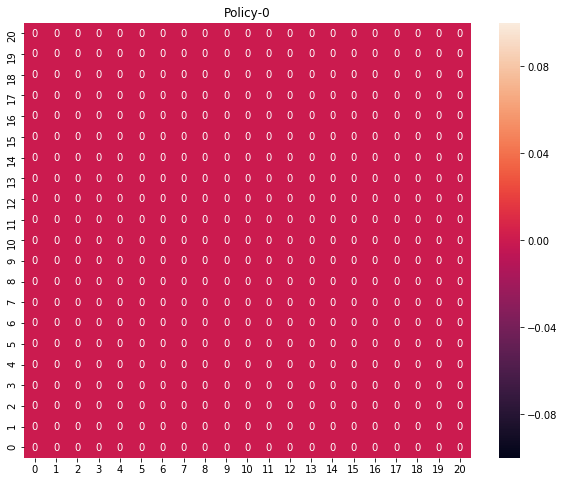

Policy Evaluation: 1
Policy Improvement: 1


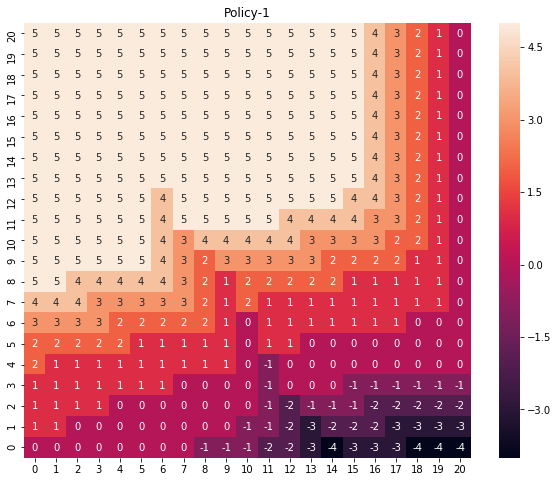

Policy Evaluation: 2
Policy Improvement: 2


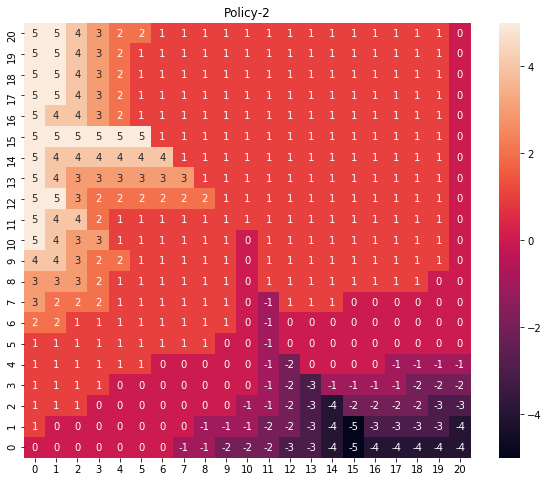

Policy Evaluation: 3
Policy Improvement: 3


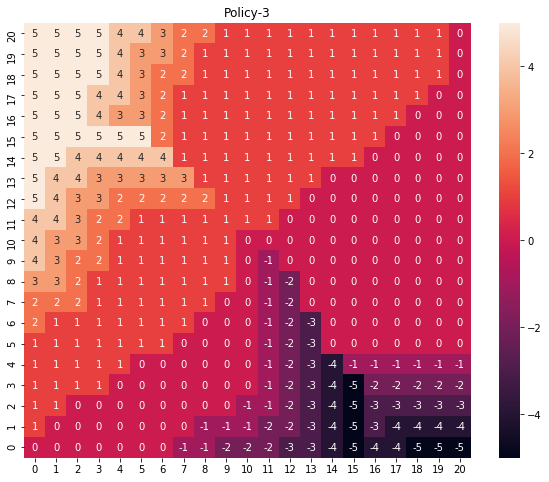

Policy Evaluation: 4
Policy Improvement: 4


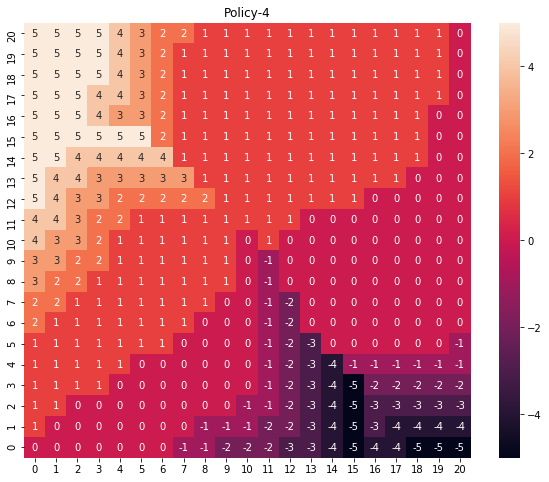

Policy Evaluation: 5
Policy Improvement: 5


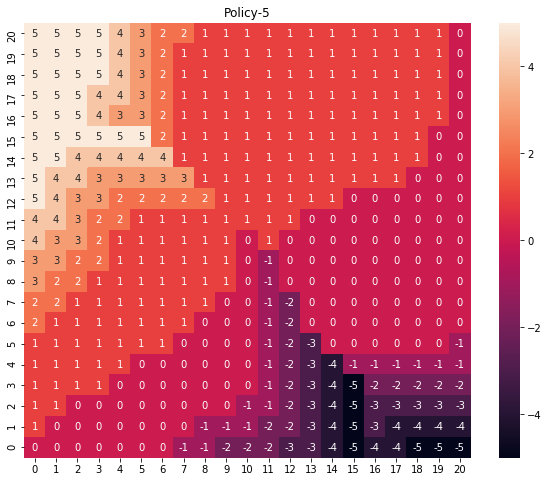

Policy Evaluation: 6
Policy Improvement: 6


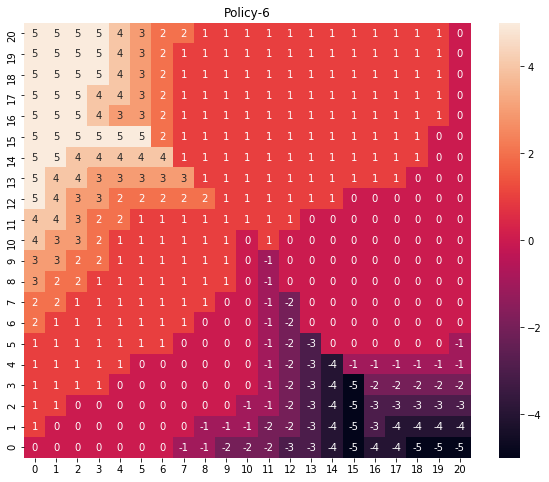

In [12]:
env = JackRental()
policy =initilalizePolicy(env)
v = initializeValueFunc(env)
plotPolicy(policy,0)
i=1
while True:
    print("Policy Evaluation:",i)
    v = policyEvaluation(policy,env,v)
    #print(np.round(np.array(list(v.values())).reshape(MAXCARS+1,MAXCARS+1),1))
    print("Policy Improvement:",i)
    isStable,newPolicy = policyImprove(policy,env,v)
    #TODO plot the policy
    plotPolicy(newPolicy,i)
    policy = newPolicy
    i +=1
#     if(i == 5):
#         break;
    if isStable == True:
        break;

In [17]:
vReshape = np.round(np.array(list(v.values())).reshape(21,21),1)

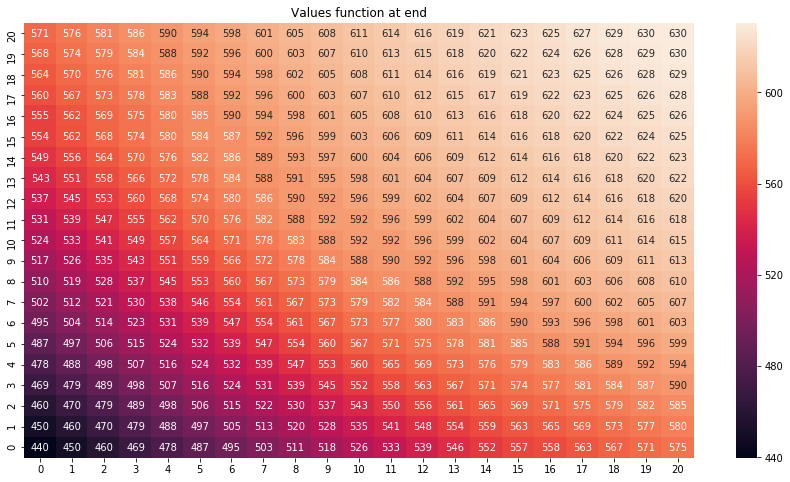

In [23]:
fig, ax = plt.subplots(figsize=(15,8))
ax = sns.heatmap(ax = ax,data = np.flip(vReshape,0), annot=True, fmt=".0f",yticklabels=[i for i in range(MAXCARS,-1,-1)])
ax.set_title('Values function at end')
plt.show()